In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import array

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import os

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/haram4th/ablearn/main/hotel_review_75000.csv")
data.head(2)

,Unnamed: 0.1,Unnamed: 0,hotelId,hotelName,tripType,tripTypeText,reviewDate,rating,description,isKorNot
0,0,356,105343,서울 웨스틴조선호텔 (The Westin Chosun Seoul),family,1박 가족 여행,2019년 1월 26일,10.0,직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...,True
1,1,357,105343,서울 웨스틴조선호텔 (The Westin Chosun Seoul),family,1박 가족 여행,2019년 2월 4일,10.0,웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...,True


In [15]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'hotelId', 'hotelName', 'tripType',
       'tripTypeText', 'reviewDate', 'rating', 'description', 'isKorNot'],
      dtype='object')

In [24]:
data = data[['rating', 'description']]

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       75000 non-null  float64
 1   description  75000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


* rating 8 이상이면 긍정 1, 미만은 부정 0 으로 해서 target 컬럼 생성
* description컬럼 토크나이징, 시퀀스로 변환, 임베딩
* train, valid, test로 데이터 분할
* 딥러닝 네트워크 생성 후 분석
* early_stopping, modelcheckpoint 
* 그래프로 loss 출력

In [18]:
data.head(2)

,rating,description
0,10.0,직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...
1,10.0,웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...


In [25]:
data['target'] = data['rating'].apply(lambda x: 1 if x >=8 else 0)

In [26]:
data.head()

,rating,description,target
0,10.0,직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...,1
1,10.0,웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...,1
2,10.0,서울시내에서 호캉스를 누릴 수 있는 곳아침 뷔페가 맛있는 곳룸서비스가 좋았음요구사항...,1
3,10.0,가격에 맞게 만족했습니다,1
4,10.0,처음 세명으로 셋팅 되어있지 않은점 빼고는 직원들의 친절도 및 서비스는 모두 맘에 ...,1


In [27]:
type(data['description']) # 리스트, np.array

pandas.core.series.Series

In [28]:
text = data['description'][0]

In [29]:
result = text_to_word_sequence(data['description'][0])
print("원문: ", text)
print("토큰화: ", result) #토큰, 코퍼스(corpus)

원문:  직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비해 약간 부족합니다
토큰화:  ['직원들', '서비스나', '마인드', '완벽합니다', '다만', '노후된', '시설과', '좁은', '라운지가', '호텔', '이름에', '비해', '약간', '부족합니다']


In [6]:
# 단어 빈도수 세기
docs = data['description']

# 토크나이저 사용법

In [30]:
# 문장 토큰화 하기
token = Tokenizer(lower=False)
token.fit_on_texts(docs)

In [ ]:
print('단어 카운트: ', token.word_counts)

In [ ]:
print('문장 카운트:', token.document_count)

In [ ]:
print('각 단어가 몇 개의 문장에 포함되어 있는가? ', token.word_docs)

In [31]:
print('각 단어에 매겨진 인덱스:', token.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
len(token.word_index)

261893

# 단어의 원-핫 인코딩

In [33]:
text = data['description'][0]
token = Tokenizer(lower=False)
token.fit_on_texts([text])
print(token.word_index)

{'직원들': 1, '서비스나': 2, '마인드': 3, '완벽합니다': 4, '다만': 5, '노후된': 6, '시설과': 7, '좁은': 8, '라운지가': 9, '호텔': 10, '이름에': 11, '비해': 12, '약간': 13, '부족합니다': 14}


In [34]:
# 단어를 벡터로 변환
x = token.texts_to_sequences([text])

In [35]:
len(token.word_index)

14

In [36]:
# 인덱스에 1을 추가해서 원-핫 인코딩 배열 만들기
word_size = len(token.word_index) + 1

In [37]:
x = to_categorical(x, num_classes=word_size)
print(x)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]]


In [38]:
x.shape

(1, 14, 15)

# 텍스트를 읽고 긍정, 부정 예측하기

In [39]:
docs = data['description']

# 긍정 리뷰는 1, 부정리뷰는 0으로 클래스 지정
classes = data['target']

In [40]:
# 토큰화
token = Tokenizer(lower=False)
token.fit_on_texts(docs)
len(token.word_index)

261893

In [41]:
# 원핫인코딩
x = token.texts_to_sequences(docs)
print(x)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
x2 = pd.Series(x)
x2

0        [268, 1162, 5870, 5689, 26, 1875, 661, 581, 48...
1        [67077, 1725, 308, 4636, 488, 566, 6066, 67078...
2        [21641, 1628, 8335, 7, 17, 42175, 3242, 849, 6...
3                                         [117, 2276, 178]
4        [214, 42176, 12702, 2929, 21643, 224, 326, 110...
                               ...                        
74995    [2226, 47880, 261879, 6346, 507, 261880, 26188...
74996    [216, 16, 261888, 136, 21461, 93, 4619, 9183, ...
74997    [27422, 20, 321, 261889, 4, 1159, 14804, 34736...
74998    [407, 67, 1, 47, 896, 973, 1440, 196, 38, 2287...
74999    [203, 1800, 57849, 12186, 165, 261892, 4611, 4...
Length: 75000, dtype: object

In [42]:
x2_len = x2.apply(len)
x2_len.max()

377

In [43]:
# 패딩 추가 pad_sequences(데이터, 가장 긴 문장의 길이)
padded_x = pad_sequences(x, 377)
print("패딩 결과", padded_x )

패딩 결과 [[     0      0      0 ...    101     83   2604]
 [     0      0      0 ...  67078     31   3858]
 [     0      0      0 ...  67082    665   4111]
 ...
 [     0      0      0 ...    195  42071  39796]
 [     0      0      0 ... 261891    502    437]
 [     0      0      0 ...   3199   8900     64]]


In [44]:
#임베딩에 입력된 단어의 수 지정
word_size = len(token.word_index) + 1

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_x, classes, test_size=0.4, random_state=7)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=7)

In [46]:
word_size

261894

In [47]:
# 단어 임베딩을 포함해서 딥러닝 모델 생성
model = Sequential()
model.add(Embedding(word_size, 32, input_length=377)) 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 377, 32)           8380608   
                                                                 
 flatten (Flatten)           (None, 12064)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12065     
                                                                 
Total params: 8,392,673
Trainable params: 8,392,673
Non-trainable params: 0
_________________________________________________________________


In [48]:
modelpath = "./model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [49]:
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
print('Accuracy: ', model.evaluate(X_test, y_test)[1])

Epoch 1/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.3637 - accuracy: 0.8385 - val_loss: 0.3108 - val_accuracy: 0.8669
Epoch 2/5
1407/1407 [==============================] - 25s 17ms/step - loss: 0.1783 - accuracy: 0.9354 - val_loss: 0.3352 - val_accuracy: 0.8636
Epoch 3/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0782 - accuracy: 0.9756 - val_loss: 0.3890 - val_accuracy: 0.8532
Epoch 4/5
1407/1407 [==============================] - 25s 17ms/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 0.4468 - val_accuracy: 0.8474
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5245 - accuracy: 0.8477
Accuracy:  0.8477333188056946


In [50]:
def plt_show(x):
    y_val_loss = history.history['val_loss']
    y_loss = history.history['loss']
    x_len = np.arange(len(y_loss))
    plt.plot(x_len, y_val_loss, marker='.', c="red", label='Testset_loss')
    plt.plot(x_len, y_loss, marker='.', c="blue", label='trainset_loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

# RNN, LSTM 텍스트 분석하기
* RNN(Recurrent Neural Network) 시간적으로 연속성이 있는 데이터를 처리하려고 만든 인공 신경망
* 이전 은닉층이 현재 은닉층의 입력이 되면서 '반복되는 순환 구조를 갖음'
* RNN의 가장 큰 차이점은 기억(memory)을 갖는 신경망
* 텍스트 분석, 시계열 데이터 분석에 활용
# LSTM
* RNN은 입력이 길어지면 가장 먼저 입력된 정보를 잊어버림(기울기 소실)
* 기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트 추가
* 정보가 소실되지 않고 계속 기억되도록 함.

In [51]:
from tensorflow.keras.layers import LSTM

In [52]:
model = Sequential()
model.add(Embedding(word_size, 32, input_length=377))
model.add(LSTM(377, activation='tanh')) # LSTM에서는 하이퍼블릭 탄젠트 활성화 함수를 사용
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 377, 32)           8380608   
                                                                 
 lstm_1 (LSTM)               (None, 377)               618280    
                                                                 
 dense_2 (Dense)             (None, 1)                 378       
                                                                 
Total params: 8,999,266
Trainable params: 8,999,266
Non-trainable params: 0
_________________________________________________________________


In [53]:
modelpath = "./model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

Epoch 1/5
1407/1407 [==============================] - 122s 85ms/step - loss: 0.3802 - accuracy: 0.8341 - val_loss: 0.3730 - val_accuracy: 0.8338
Epoch 2/5
1407/1407 [==============================] - 119s 85ms/step - loss: 0.1923 - accuracy: 0.9281 - val_loss: 0.3831 - val_accuracy: 0.8525
Epoch 3/5
1407/1407 [==============================] - 120s 85ms/step - loss: 0.0863 - accuracy: 0.9714 - val_loss: 0.4918 - val_accuracy: 0.8457
Epoch 4/5
1407/1407 [==============================] - 120s 85ms/step - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.5797 - val_accuracy: 0.8455
Epoch 5/5
469/469 [==============================] - 13s 28ms/step - loss: 0.6422 - accuracy: 0.8298
Accuracy:  0.829800009727478


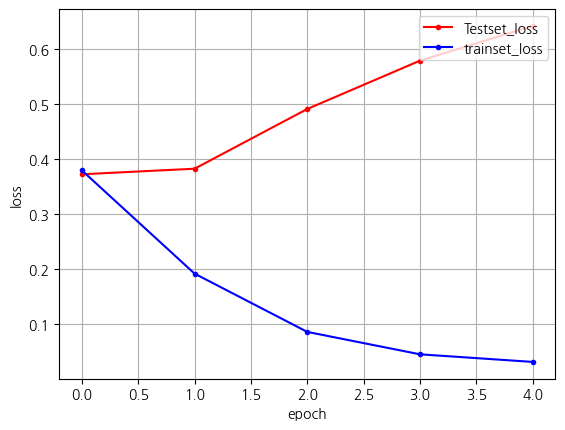

In [54]:
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
print('Accuracy: ', model.evaluate(X_test, y_test)[1])
plt_show(history)

# LSTM과 CNN 조합 모델로 분석

In [56]:
from tensorflow.keras.layers import Dropout, Activation, Conv1D, MaxPooling1D

In [57]:
model = Sequential()
model.add(Embedding(word_size,32,input_length=377))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(377))
model.add(Dense(128), activation='relu')
model.add(Dense(64), activation='relu')
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 377, 32)           8380608   
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 373, 64)           10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 377)               666536    
                                                                 
 dense_3 (Dense)             (None, 20)                7560      
                                                      

Epoch 1/5
1407/1407 [==============================] - 62s 41ms/step - loss: 0.3812 - accuracy: 0.8349 - val_loss: 0.3234 - val_accuracy: 0.8654
Epoch 2/5
1407/1407 [==============================] - 57s 41ms/step - loss: 0.2195 - accuracy: 0.9154 - val_loss: 0.3557 - val_accuracy: 0.8542
Epoch 3/5
1407/1407 [==============================] - 57s 41ms/step - loss: 0.1186 - accuracy: 0.9571 - val_loss: 0.4510 - val_accuracy: 0.8445
Epoch 4/5
1407/1407 [==============================] - 57s 41ms/step - loss: 0.0785 - accuracy: 0.9727 - val_loss: 0.5612 - val_accuracy: 0.8365
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.7000 - accuracy: 0.8320
Accuracy:  0.8320000171661377


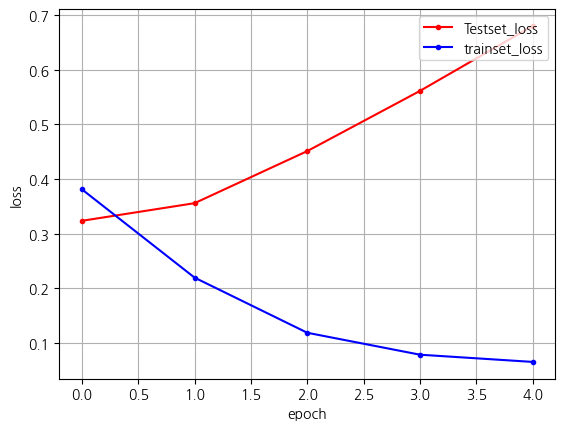

In [58]:
modelpath = "./model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
print('Accuracy: ', model.evaluate(X_test, y_test)[1])
plt_show(history)

# Attention 을 이용한 분석

In [59]:
!pip install attention

In [60]:
from attention import Attention

In [61]:
model = Sequential()
model.add(Embedding(word_size, 32, input_length=377))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 377, 32)           8380608   
                                                                 
 dropout_1 (Dropout)         (None, 377, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 377, 64)           24832     
                                                                 
 attention (Attention)       (None, 128)               20480     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 128)              

Epoch 1/5
1407/1407 [==============================] - 55s 37ms/step - loss: 0.3659 - accuracy: 0.8419 - val_loss: 0.3139 - val_accuracy: 0.8637
Epoch 2/5
1407/1407 [==============================] - 52s 37ms/step - loss: 0.2021 - accuracy: 0.9248 - val_loss: 0.3366 - val_accuracy: 0.8600
Epoch 3/5
1407/1407 [==============================] - 52s 37ms/step - loss: 0.1033 - accuracy: 0.9645 - val_loss: 0.4414 - val_accuracy: 0.8568
Epoch 4/5
1407/1407 [==============================] - 52s 37ms/step - loss: 0.0672 - accuracy: 0.9778 - val_loss: 0.4913 - val_accuracy: 0.8513
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.5306 - accuracy: 0.8408
Accuracy:  0.8407999873161316


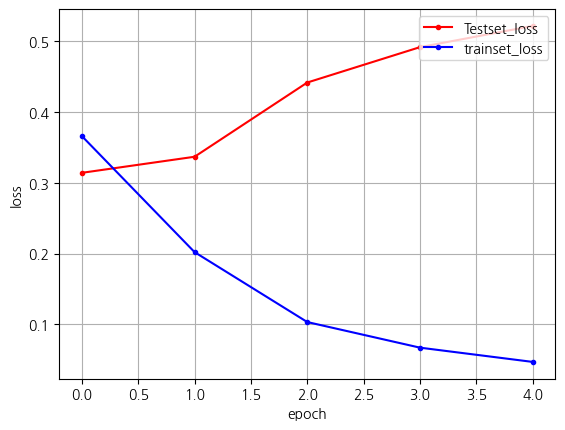

In [62]:
modelpath = "./model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
print('Accuracy: ', model.evaluate(X_test, y_test)[1])
plt_show(history)